# Курс "Обработка изображений" ВШЭ

## 2 модуль

### Коррекция яркости и цвета

#### Линейная коррекция контраста

In [1]:
import matplotlib.pyplot as plt

Линейное выравнивание яркости - применение к каждому пикселю функцию выранивания

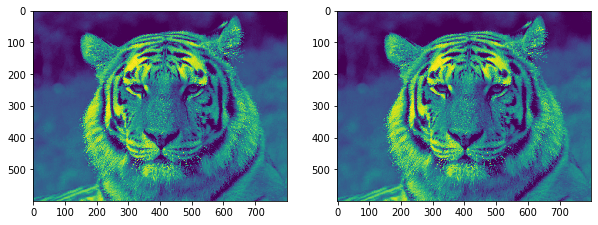

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
ax = axes.ravel()

from skimage.io import imread, imsave
import numpy

img = imread("https://stepik.org/media/attachments/lesson/58402/tiger-low-contrast.png")

ax[0].imshow(img)

img = img - numpy.min(img)
img = img_as_float(img)
img = img * (255 / numpy.max(img))

ax[1].imshow(img.astype("uint8"))

Линейное выравнивание не всегда работает корректно из-за больших выбросов, 
поэтому можно отбросить 5% верхних и нижних пикселей

Устойчивый автоконтраст. Было решено вырезать по 5% с использованием гистограммы, так как все пиксели целочисленные, а асимптотика построение гистограммы меньше чем сортировка.

129 208


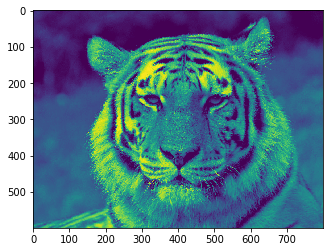

In [30]:
from skimage.io import imread, imsave
from skimage import img_as_float
import numpy

img = imread("https://stepik.org/media/attachments/lesson/58402/tiger-low-contrast.png")

plt.imshow(img)

# Построение гистограммы изображения
def get_hist(img):
    hist = [0 for i in range(256)]
    
    for i in img:
        for j in i:
            hist[int(j)] += 1
            
    return hist

k = round(img.size * 0.05)
hist = get_hist(img)
s = 0

for i in range(256):
    s += hist[i]
    if s >= k:
        min_ind = i
        break

s = 0
for i in range(256):
    s += hist[-1-i]
    if s >= k:
        max_ind = 255 - i
        break
        
print(min_ind, max_ind)

Устойчивый автоконтраст черно-белого изображения. Объединяем все методы.

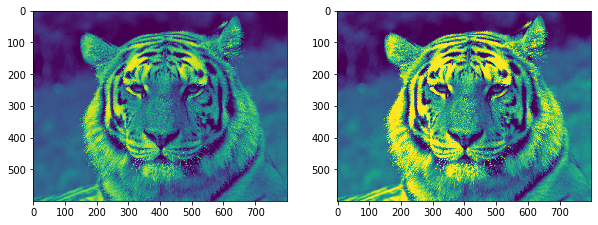

In [24]:
from skimage.io import imread, imsave
from skimage import img_as_float
import numpy

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
ax = axes.ravel()

def get_hist(img):
    hist = [0 for i in range(256)]
    
    for i in img:
        for j in i:
            hist[int(j)] += 1
            
    return hist

def trip5proc(img):
    k = round(img.size * 0.05)
    hist = get_hist(img)
    s = 0

    for i in range(256):
        s += hist[i]
        if s >= k:
            min_ind = i
            break

    s = 0
    for i in range(256):
        s += hist[-1-i]
        if s >= k:
            max_ind = 255 - i
            break
    
    return numpy.clip(img, min_ind, max_ind)

img = imread("https://stepik.org/media/attachments/lesson/58402/tiger-low-contrast.png")

ax[0].imshow(img)

img = trip5proc(img)
img = img - numpy.min(img)
img = img_as_float(img)
img = img * (255 / numpy.max(img))

ax[1].imshow(img.astype("uint8"))

#imsave("out_img.png", img.astype("uint8"))

#### Коррекция контраста цветного изображения

Устойчивый цветной автоконтраст. В данном случае изображение нужно перевести в YUV, поэтому
пиксели будут типа float и построить гистограмму будет не разумно, поэтому было принято решение
вырезать по 5% с использованием сортировки.

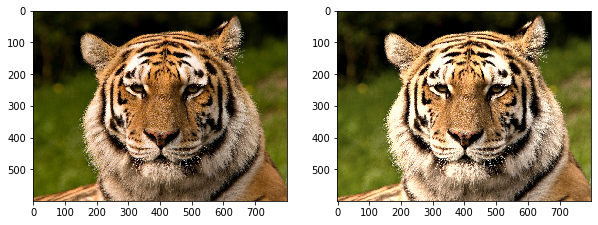

In [36]:
from skimage.io import imread, imsave
from skimage import img_as_float, img_as_ubyte
import numpy
import copy

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
ax = axes.ravel()

def trip5proc(img):
    k = round(img.size * 0.05)
    values = copy.deepcopy(numpy.reshape(img, (1, -1))[0])
    values.sort()
    
    x_min = values[k]
    x_max = values[-k]
    
    return numpy.clip(img, x_min, x_max)

def strech_hist(img):
    img = trip5proc(img)
    
    img = img - numpy.min(img)
    img = img_as_float(img)
    img = img / numpy.max(img)
    
    return numpy.clip(img, 0, 1)

img = img_as_float(imread("https://stepik.org/media/attachments/lesson/60609/tiger-color.png"))

ax[0].imshow(img)

r, g, b = [img[:, :, i] for i in range(3)]

y = 0.2126 * r + 0.7152 * g + 0.0722 * b 
u = -0.0999 * r - 0.3360 * g + 0.4360 * b 
v = 0.6150 * r - 0.5586 * g - 0.0563 * b

y = strech_hist(y)

r = y + 1.2803 * v 
g = y - 0.2148 * u - 0.3805 * v 
b = y + 2.1279 * u

img = numpy.dstack((r, g, b))
img = numpy.clip(img, 0, 1)
img = img_as_ubyte(img)

ax[1].imshow(img)

#imsave("out_img.png", img)

#### Баланс белого. Модель "серого мира"

Преобразование серого мира с использованием функций.

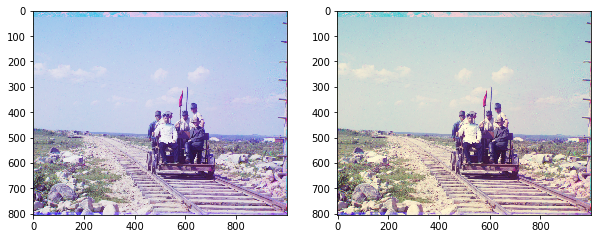

In [28]:
from skimage.io import imread, imsave
from skimage import img_as_float
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
ax = axes.ravel()

img = img_as_float(imread("https://stepik.org/media/attachments/lesson/60610/railroad.png"))

ax[0].imshow(img)

r, g, b = [img[:, :, i] for i in range(3)]

rn = np.mean(r); gn = np.mean(g); bn = np.mean(b);
avg = (rn + gn + bn) / 3
rw = rn / avg; gw = gn / avg; bw = bn / avg; 

img = np.dstack((r / rw, g / gw, b / bw))
img = np.clip(img, 0, 1)

ax[1].imshow(img)

#imsave("out_img.png", img)

#### Выравнивание гистограммы

Было видвинута гипотеза, что качество изображения лучше, если гистограмма будет линейно расти, поэтому
нужно было "выровнить" изображение так, чтобы ее гистограмма росла линейно.
Это достигается элементарными математическими операциями.

AttributeError: 'numpy.ndarray' object has no attribute 'show'

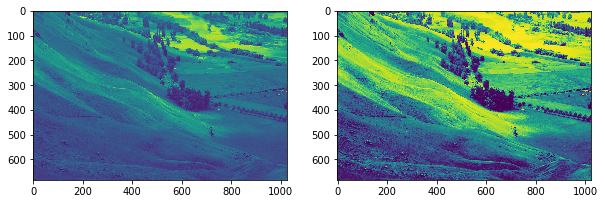

In [33]:
from skimage.io import imread, imsave

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
ax = axes.ravel()

img = imread("https://stepik.org/media/attachments/lesson/60611/landscape.png")

ax[0].imshow(img)

hist = [0 for i in range(256)]
cdf = [0 for i in range(256)]

for row in img:
    for pix in row:
        hist[pix] += 1
        
cdf[0] = hist[0]
cdfmin = 100000000 if cdf[0] == 0 else cdf[0]

for i in range(1, 256):
    cdf[i] += cdf[i-1] + hist[i]
    
    if cdf[i] != 0 and cdf[i] < cdfmin:
        cdfmin = cdf[i]
        
for i in range(len(img)):
    for j in range(len(img[i])):
        pix = img[i][j]
        
        img[i][j] = round((cdf[pix] - cdfmin) / (img.size - 1) * 255)

ax[1].imshow(img)

#imsave("out_img.png", img)

И как оказалось да, изображение становится лучше.